In [ ]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv
from langchain.output_parsers import OutputFixingParser
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from tqdm import tqdm

In [ ]:
dataset = pd.read_csv("../data/train_question_plus.csv")
dataset.head()

,id,paragraph,question,choices,answer,question_plus
0,generation-for-nlp-425,"상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服)...",상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?,"['ㄱ, ㄴ', 'ㄱ, ㄷ', 'ㄴ, ㄹ', 'ㄷ, ㄹ']",2,ㄱ.기 사환국으로 정권을 장악하였다 .ㄴ.인 조반정을 주도 하여 집권세력이 되었다 ...
1,generation-for-nlp-427,나는 삼한(三韓) 산천의 음덕을 입어 대업을 이루었다.(가)는/은 수덕(水德)이 순...,(가) 지역에 대한 설명으로 옳은 것은?,"['이곳에 대장도감을 설치하여 재조대장경을 만들었다.', '지눌이 이곳에서 수선사 ...",4,NaN
2,generation-for-nlp-428,이 날 소정방이 부총관 김인문 등과 함께 기 벌포에 도착하여 백제 군사와 마주쳤다....,밑줄 친 ‘그’에 대한 설명으로 옳은 것은?,"['살수에서 수의 군대를 물리쳤다 .', '김춘추 의 신라 왕위 계승을 지원하였다 ...",2,NaN
3,generation-for-nlp-429,"선비들 수만 명이 대궐 앞에 모여 만 동묘와 서원을 다시 설립할 것을 청하니, (가...",(가) 인물이 추진한 정책으로 옳지 않은 것은?,"['사창제를 실시하였다 .', '대전회통을 편찬하였다 .', '비변사의 기능을 강화...",3,NaN
4,generation-for-nlp-431,(가)의 사신 고제덕 등이 일본에 와서 왕이 보낸 국서를 전하였다. 그 국서에 이르...,(가) 국가에 대한 설명으로 옳은 것은?,"['나 당연합군의 공격으로 멸망하였다 .', '9주 5소경의 지방 행정 구역을 두었...",3,NaN


In [ ]:
# note: dataset.head() 동작으로 칼럼 명 정보륾 확인하고 동작해주세요.
PARAGRAPH = "paragraph"
QUESTION = "question"
CHOICES = "choices"
ANSWER = "answer"
QUESTION_PLUS = "question_plus"

GPT 4o mini 세팅


In [ ]:
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
if not OPENAI_API_KEY:
    raise ValueError("OpenAI API 키를 .env 파일에 저장하세요.")

In [ ]:
prompt = PromptTemplate.from_template(
    """
### Prompt
You are an AI trained to classify questions based on the problem-solving strategies needed, using four detailed categories.

**Categories and Descriptions**:
1. **사실 확인**: The information required to solve the question is fully contained in the paragraph. The problem-solving strategy is to compare the question and choices with the paragraph to verify factual information.
2. **도출형 추론**: The answer requires additional linguistic inference beyond the information in the paragraph. The strategy involves processing the paragraph for insights that aren't directly stated and comparing these insights with the choices.
3. **연결형 추론**: The solution involves understanding higher-level concepts or linking the paragraph to background knowledge. The strategy includes analyzing the paragraph's overarching theme or background to connect with the choices.
4. **논리적 추론**: The question needs logical or numerical reasoning. The strategy requires extracting information from the paragraph and using logical/mathematical operations to deduce the correct answer.

### Examples

**Example 1**: 사실 확인  
- **Paragraph:** “비잔틴의 학문과의 교류를 통해 학자 아리스토텔레스를 플라톤으로 대체하는 것이 빨라졌습니다. 이미 페레라 공의회(1438년)에서 명목상으로 동서 교회를 통합하였으며, 비잔틴 제국이 아리스토텔레스에 비해 플라톤의 우월성을 유지한 지에 대한 논쟁이 있었습니다. 코시모와 로렌초 데 메디치는 둘다 플라톤에 깊이 빠져있었으며; 코시모가 피렌체 아카데미를 설립하고 로렌초가 이를 계속 유지했으며, 이 아카데미는 주로 플라톤에 대한 연구에 전념했습니다&…그러나 당시의 인문주의자들은 고대의 지식을 습득하는 데 너무 급급하여 가치있는 무언가를 창출할 수 없었습니다.”
- **Question:** 이 구절을 통해 페레라 공의회가 한 일을 유추할 수 있습니다
- **Choices**
    1. 피렌체 아카데미의 기초를 닦았습니다
    2. 동서 교회간의 불화를 영구적으로 화해시켰습니다
    3. 서유럽에서 고전철학의 재발견을 촉진시켰습니다
    4. 비잔틴 제국이 피렌체의 학문을 배우는 것을 허용하였습니다
- **Thinking**: 주어진 문단에서 페라라 공의회(1438년)가 명목상으로 동서 교회를 통합했다고 언급하고 있습니다. 이러한 통합은 비잔틴 제국과 서유럽 간의 학문적 교류를 촉진시켰으며, 특히 플라톤 철학에 대한 관심이 증가하는 계기가 되었습니다. 따라서, 페라라 공의회는 서유럽에서 고전 철학의 재발견을 촉진하는 데 중요한 역할을 했다고 볼 수 있습니다. 이러한 이유로 3번 선택지가 정답입니다.
- **Category**: 사실 확인

**Example 2**: 도출형 추론  
- **Paragraph**
    이 지문에 나타난 정보는 무엇입니까? 우리는 이 영구적이며 번복할 수 없는 칙령을 통해 확립하고 선포한다. "첫째, 이전 모든 고난스러운 기간에 ... 일방 또는 타방 당사자가 행한 모든 일에 대한 기억은, 마치 전혀 일어나지 않았던 것처럼 말소하고 잊는다. … "우리는 우리 왕국과 우리 지배를 받는 나라, 그 행사가 중단된 나라의 모든 장소와 지방에서 가톨릭 사도와 로마 종교가 여하한 문제나 방해 없이 행사 평화롭고 자유롭게 행해지도록 회복 및 재건될 것을 명한다. … "그리고 우리 백성들 사이 분쟁이나 의견차가 발생할 여지를 남기지 않고자, 우리는 개혁파라 불리는 종교가 우리 왕국과 우리가 지배하는 국가의 모든 도시와 장소에서 방해 받거나, 추행을 당하거나, 종교 문제에 있어 양심에 어긋나는 일을 하도록 강요당하지 않으며 살고 거주하도록 허용해 왔고 지금 이로써 허용한다. …" 프랑스의 앙리 4세, 낭트 칙령, 1598년
- **Question**        
    본문을 통해 추론할 수 있는 점을 고르십시오.
- **Choices**
    1. 헨리 4세는 가톨릭 신자였습니다.
    2. 헨리 4세는 개신교인이었습니다.
    3. 1598년 이전 프랑스에는 종교적 갈등이 없었습니다.
    4. 1598년 이전 프랑스는 종교적 갈등에 시달렸습니다.
- **Thinking**: 문단에서 "이전 모든 고난스러운 기간에 ... 일방 또는 타방 당사자가 행한 모든 일에 대한 기억은, 마치 전혀 일어나지 않았던 것처럼 말소하고 잊는다."라고 언급하고 있습니다. 이는 과거의 갈등과 분쟁을 잊고자 하는 의도를 나타내며, 따라서 1598년 이전에 프랑스가 종교적 갈등을 겪었음을 추론할 수 있습니다. 따라서 4번 선택지가 정답입니다.
- **Category**: 도출형 추론

**Example 3**: 연결형 추론  
- **Paragraph**: 상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服) 절차에 대하여 논한 것이 신과는 큰 차이가 있었습니다 . 장자를 위하여 3년을 입는 까닭은 위로 ‘정체(正體)’가 되기 때문이고 또 전 중(傳重: 조상의 제사나 가문의 법통을 전함)하기 때문입니다 . …(중략) … 무엇보다 중요한 것은 할아버지와 아버지의 뒤를 이은 ‘정체’이지, 꼭 첫째이기 때문에 참 최 3년 복을 입는 것은 아닙니다 .”라고 하였다 .－현종실록 －
- **Question**: 상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?
- **Choices**
    1. 기 사환국으로 정권을 장악하였다 .
    2. 인 조반정을 주도 하여 집권세력이 되었다 .
    3. 정조 시기에 탕평 정치의 한 축을 이루었다 .
    4. 이 이와 성혼의 문인을 중심으로 형성되었다.
- **Thinking**: 주어진 문단은 조선 시대 예송 논쟁 중 송준길의 상소 내용을 담고 있습니다. 송준길은 서인(西人) 붕당의 주요 인물로, 서인은 1623년 인조반정을 주도하여 집권 세력이 되었습니다. 따라서, 상소한 인물이 속한 붕당에 대한 설명으로 2번 선택지인 "인조반정을 주도하여 집권세력이 되었다"가 옳습니다.
- **Category**: 연결형 추론

**Example 4**: 논리적 추론  
- **Paragraph**: 총 공급 곡선이 왼쪽으로 이동하면 균형 물가 수준과 균형 산출량은 어떻게 되겠습니까? 총 공급 곡선이 위로 기울어진다고 가정합니다.
- **Question:** 총 공급 곡선이 왼쪽으로 이동하면 균형 물가 수준과 균형 산출량은 어떻게 되겠습니까?
- **Choices**
    1. 균형 물가 수준은 증가하는 반면 균형 산출량은 감소한다.
    2. 균형 물가 수준은 감소하는 반면 균형 산출량은 증가한다.
    3. 균형 물가 수준과 산출량이 증가한다.
    4. 균형 물가 수준과 산출량이 감소한다.
- **Thinking**: 총공급곡선이 왼쪽으로 이동하면, 이는 생산 비용 증가나 생산성 감소 등으로 인해 기업들이 동일한 물가 수준에서 이전보다 적은 양을 생산하려는 상황을 나타냅니다. 이러한 변화는 경제의 균형점에서 다음과 같은 결과를 초래합니다: 균형 물가 수준의 상승: 총공급이 감소하면 시장에서 재화와 서비스의 공급이 줄어들어 희소성이 증가합니다. 이로 인해 가격이 상승하여 균형 물가 수준이 높아집니다. 균형 산출량의 감소: 공급 감소로 인해 전체 생산량이 줄어들어 균형 산출량이 감소합니다. 따라서, 총공급곡선이 왼쪽으로 이동하면 균형 물가 수준은 증가하고 균형 산출량은 감소하게 되므로, 1번 선택지가 정답입니다.
- **Category**: 논리적 추론

**Now, your task**:  
Classify the following question based on the paragraph and problem-solving strategy needed.

- **Paragraph**: {paragraph}  
- **Question**: {question}  
- **Choices**: {choices}
- **thinking**: YOUR ANSWER
- **Category**: YOUR ANSWER

ONLY return a JSON output with the following keys:
- "category": The classified category name.
- "thinking": A brief explanation of why this category was chosen based on the given strategy and paragraph.

if you don't answer in JSON output, you will be punished.
"""
)

output_parser = JsonOutputParser()

In [ ]:
llm = ChatOpenAI(
    model="gpt-4o-mini", temperature=0, max_tokens=None, timeout=None, max_retries=2, api_key=OPENAI_API_KEY
)
fixing_parser = OutputFixingParser.from_llm(parser=output_parser, llm=llm)

chain = prompt | llm | fixing_parser

In [ ]:
def classify_problem(data: pd.Series) -> tuple[str, str]:
    """프롬프트에 따라 LLM이 문제 데이터를 분류하고 결과를 문자열로 반환하는 함수

    Args:
        data (pd.Series): 제공된 데이터셋의 한 행(row), 문제 하나

    Returns:
        tuple[str, str]: 문제가 분류된 카테고리와 도출된 이유
    """
    response = chain.invoke({"paragraph": data[PARAGRAPH], "choices": data[CHOICES], "question": data[QUESTION]})
    category, reason = response["category"], response["thinking"]
    return category, reason


# test
test_data = dataset.iloc[20]
test_results = classify_problem(test_data)
print(f"테스트 데이터: {test_data}, 테스트 결과: {test_results}")

테스트 데이터: id                                          generation-for-nlp-450
paragraph        ㉠은/는 만민공동회를 개최하여 외국 열강의 내정간섭을 비판하였다. 또 정부 관리들까...
question                                      ㉠ 단체에 대한 설명으로 옳은 것은?
choices          ['국정의 기본 강령인 홍범 14조를 발표하였다.', '러시아가 절영도조차를 요구하...
answer                                                           2
question_plus                                                  NaN
Name: 20, dtype: object, 테스트 결과: ('사실 확인', '주어진 문단에서 ㉠ 단체가 만민공동회를 개최하고 헌의 6조를 채택한 사실이 언급되어 있습니다. 질문은 ㉠ 단체에 대한 설명을 요구하고 있으며, 선택지들은 이 단체의 활동이나 주장에 대한 사실을 확인하는 것이므로, 주어진 정보와 선택지를 비교하여 올바른 사실을 확인하는 전략이 필요합니다.')


In [ ]:
tqdm.pandas()

In [ ]:
mpl.rcParams["font.family"] = "AppleGothic"
mpl.rcParams["axes.unicode_minus"] = False

# 전체 데이터에 대해 분류 진행


In [ ]:
dataset[["category", "reason"]] = dataset.progress_apply(lambda x: pd.Series(classify_problem(x)), axis=1)
# 약 90분 소요

100%|██████████| 2029/2029 [1:17:10<00:00,  2.28s/it]


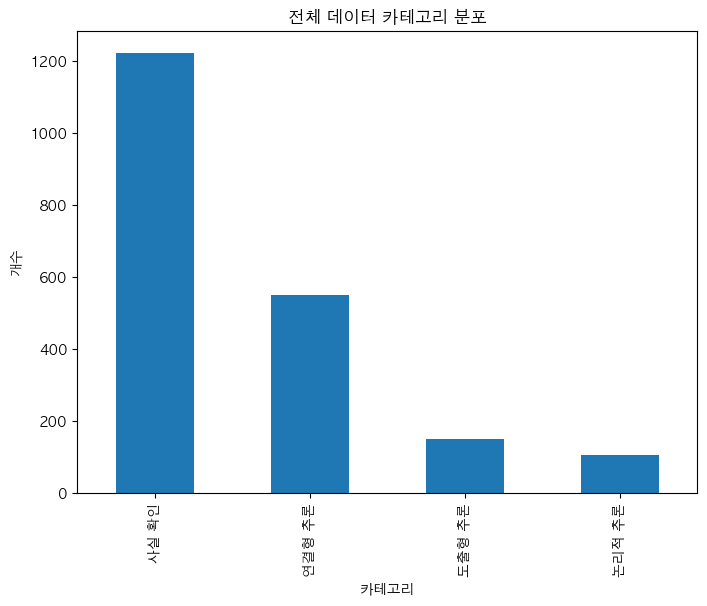

In [11]:
category_counts = dataset["category"].value_counts()

plt.figure(figsize=(8, 6))
category_counts.plot(kind="bar")
plt.title("전체 데이터 카테고리 분포")
plt.xlabel("카테고리")
plt.ylabel("개수")
plt.show()

In [ ]:
dataset.to_csv("../data/train_problem_categorized.csv")